In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
gc.enable()

train = pd.read_csv('training_set.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']
train_det = train.where(train['detected'] == 1)
train_u = train_det.where(train_det['passband'] == 0)
train_g = train_det.where(train_det['passband'] == 1)
train_r = train_det.where(train_det['passband'] == 2)
train_i = train_det.where(train_det['passband'] == 3)
train_z = train_det.where(train_det['passband'] == 4)
train_y = train_det.where(train_det['passband'] == 5)

aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std','skew', 'cumsum'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

aggs_det = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['mean', 'std', 'var'],
    'flux': ['min', 'max', 'skew'],
}

aggs_bands = {
    'flux': ['min', 'max', 'mean', 'skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
agg_train_det = train_det.groupby('object_id').agg(aggs_det)
agg_train_u = train_u.groupby('object_id').agg(aggs_bands)
agg_train_g = train_g.groupby('object_id').agg(aggs_bands)
agg_train_r = train_r.groupby('object_id').agg(aggs_bands)
agg_train_i = train_i.groupby('object_id').agg(aggs_bands)
agg_train_z = train_z.groupby('object_id').agg(aggs_bands)
agg_train_y = train_y.groupby('object_id').agg(aggs_bands)

new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
new_columns_det = [
    k + '_' + agg for k in aggs_det.keys() for agg in aggs_det[k]
]
new_columns_bands = [
    k + '_' + agg for k in aggs_bands.keys() for agg in aggs_bands[k]
]

agg_train.columns = new_columns
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

agg_train_det.columns = new_columns_det
agg_train_det['mjd_diff'] = agg_train_det['mjd_max'] - agg_train_det['mjd_min']
agg_train_det['flux_diff'] = agg_train_det['flux_max'] - agg_train_det['flux_min']
agg_train_det['flux_kurt'] = train_det.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
mjd_fluxmax_ind = train_det.groupby('object_id')['flux'].idxmax()
flux_mjdmax_ind = train_det.groupby('object_id')['mjd'].idxmax()
flux_mjdmin_ind = train_det.groupby('object_id')['mjd'].idxmin()
mjd_fluxmax_set = train_det.iloc[mjd_fluxmax_ind].values[:,1]
flux_mjdmax_set = train_det.iloc[flux_mjdmax_ind].values[:,3]
flux_mjdmin_set = train_det.iloc[flux_mjdmin_ind].values[:,3]
agg_train_det['mjd_fluxmax'] = mjd_fluxmax_set
agg_train_det['flux_mjdmax'] = flux_mjdmax_set
agg_train_det['flux_mjdmin'] = flux_mjdmin_set

agg_train_u.columns = new_columns_bands
agg_train_u['flux_kurt'] = train_u.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
agg_train_g.columns = new_columns_bands
agg_train_g['flux_kurt'] = train_g.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
agg_train_r.columns = new_columns_bands
agg_train_r['flux_kurt'] = train_r.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
agg_train_i.columns = new_columns_bands
agg_train_i['flux_kurt'] = train_i.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
agg_train_z.columns = new_columns_bands
agg_train_z['flux_kurt'] = train_z.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
agg_train_y.columns = new_columns_bands
agg_train_y['flux_kurt'] = train_y.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)

agg_train_det.columns = agg_train_det.columns + "_det"
agg_train_u.columns = agg_train_u.columns + "_u"
agg_train_g.columns = agg_train_g.columns + "_g"
agg_train_r.columns = agg_train_r.columns + "_r"
agg_train_i.columns = agg_train_i.columns + "_i"
agg_train_z.columns = agg_train_z.columns + "_z"
agg_train_y.columns = agg_train_y.columns + "_y"

del mjd_fluxmax_ind, flux_mjdmax_ind, flux_mjdmin_ind, mjd_fluxmax_set, flux_mjdmax_set, flux_mjdmin_set
del agg_train_det['mjd_max_det'], agg_train_det['mjd_min_det']
del agg_train_det['flux_max_det'], agg_train_det['flux_min_det']
del agg_train_det['mjd_fluxmax_det'], agg_train_det['flux_mjdmax_det'], agg_train_det['flux_mjdmin_det']

agg_train = pd.concat([agg_train, agg_train_det, agg_train_u, agg_train_g, agg_train_r, agg_train_i, agg_train_z, agg_train_y], axis=1, join='inner')

agg_train.index = agg_train.index.map(int)
agg_train.index.name = 'object_id'

del train, train_det, train_u, train_g, train_r, train_i, train_z, train_y, agg_train_det, agg_train_u, agg_train_g, agg_train_r, agg_train_i, agg_train_z, agg_train_y
gc.collect()

264

In [3]:
meta_train = pd.read_csv('training_set_metadata_head_oldlab.csv')
sn_train = pd.read_csv('supernova_train.csv')

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

full_train = full_train.reset_index().merge(
    right=sn_train,
    how='outer',
    on='object_id'
)

full_train['distmod'].fillna(0, inplace=True)

full_train['abs_mag'] = -2.5*np.log10(full_train['flux_max']) - full_train['distmod']
full_train['abs_mag_uband'] = -2.5*np.log10(full_train['flux_max_u']) - full_train['distmod']
full_train['abs_mag_gband'] = -2.5*np.log10(full_train['flux_max_g']) - full_train['distmod']
full_train['abs_mag_rband'] = -2.5*np.log10(full_train['flux_max_r']) - full_train['distmod']
full_train['abs_mag_iband'] = -2.5*np.log10(full_train['flux_max_i']) - full_train['distmod']
full_train['abs_mag_zband'] = -2.5*np.log10(full_train['flux_max_z']) - full_train['distmod']
full_train['abs_mag_yband'] = -2.5*np.log10(full_train['flux_max_y']) - full_train['distmod']
full_train['abs_mag_u_g_band'] = full_train['abs_mag_uband'] - full_train['abs_mag_gband']
full_train['abs_mag_g_r_band'] = full_train['abs_mag_gband'] - full_train['abs_mag_rband']
full_train['abs_mag_r_i_band'] = full_train['abs_mag_rband'] - full_train['abs_mag_iband']
full_train['abs_mag_i_z_band'] = full_train['abs_mag_iband'] - full_train['abs_mag_zband']
full_train['abs_mag_z_y_band'] = full_train['abs_mag_zband'] - full_train['abs_mag_yband']
full_train['t0_u_t0_g'] = full_train['t_0_u'] - full_train['t_0_g']
full_train['t0_g_t0_r'] = full_train['t_0_g'] - full_train['t_0_r']
full_train['t0_r_t0_i'] = full_train['t_0_r'] - full_train['t_0_i']
full_train['t0_i_t0_z'] = full_train['t_0_i'] - full_train['t_0_z']
full_train['t0_z_t0_y'] = full_train['t_0_z'] - full_train['t_0_y']
full_train['fit_maxflux_u'] = 0.5*full_train['A_u'] + full_train['B_u']
full_train['fit_maxflux_g'] = 0.5*full_train['A_g'] + full_train['B_g']
full_train['fit_maxflux_r'] = 0.5*full_train['A_r'] + full_train['B_r']
full_train['fit_maxflux_i'] = 0.5*full_train['A_i'] + full_train['B_i']
full_train['fit_maxflux_z'] = 0.5*full_train['A_z'] + full_train['B_z']
full_train['fit_maxflux_y'] = 0.5*full_train['A_y'] + full_train['B_y']
full_train['fit_abs_mag_u'] = -2.5*np.log10(full_train['fit_maxflux_u']) - full_train['distmod']
full_train['fit_abs_mag_g'] = -2.5*np.log10(full_train['fit_maxflux_g']) - full_train['distmod']
full_train['fit_abs_mag_r'] = -2.5*np.log10(full_train['fit_maxflux_r']) - full_train['distmod']
full_train['fit_abs_mag_i'] = -2.5*np.log10(full_train['fit_maxflux_i']) - full_train['distmod']
full_train['fit_abs_mag_z'] = -2.5*np.log10(full_train['fit_maxflux_z']) - full_train['distmod']
full_train['fit_abs_mag_y'] = -2.5*np.log10(full_train['fit_maxflux_y']) - full_train['distmod']
full_train['fit_max_u_max_g'] = full_train['fit_maxflux_u'] - full_train['fit_maxflux_g']
full_train['fit_max_g_max_r'] = full_train['fit_maxflux_g'] - full_train['fit_maxflux_r']
full_train['fit_max_r_max_i'] = full_train['fit_maxflux_r'] - full_train['fit_maxflux_i']
full_train['fit_max_i_max_z'] = full_train['fit_maxflux_i'] - full_train['fit_maxflux_z']
full_train['fit_max_z_max_y'] = full_train['fit_maxflux_z'] - full_train['fit_maxflux_y']
full_train['A_u'] = np.log10(full_train['A_u'])
full_train['B_u'] = np.log10(full_train['B_u'])
full_train['A_g'] = np.log10(full_train['A_g'])
full_train['B_g'] = np.log10(full_train['B_g'])
full_train['A_r'] = np.log10(full_train['A_r'])
full_train['B_r'] = np.log10(full_train['B_r'])
full_train['A_i'] = np.log10(full_train['A_i'])
full_train['B_i'] = np.log10(full_train['B_i'])
full_train['A_z'] = np.log10(full_train['A_z'])
full_train['B_z'] = np.log10(full_train['B_z'])
full_train['A_y'] = np.log10(full_train['A_y'])
full_train['B_y'] = np.log10(full_train['B_y'])
full_train['A_u'].fillna(-100, inplace=True)
full_train['B_u'].fillna(-100, inplace=True)
full_train['A_g'].fillna(-100, inplace=True)
full_train['B_g'].fillna(-100, inplace=True)
full_train['A_r'].fillna(-100, inplace=True)
full_train['B_r'].fillna(-100, inplace=True)
full_train['A_i'].fillna(-100, inplace=True)
full_train['B_i'].fillna(-100, inplace=True)
full_train['A_z'].fillna(-100, inplace=True)
full_train['B_z'].fillna(-100, inplace=True)
full_train['A_y'].fillna(-100, inplace=True)
full_train['B_y'].fillna(-100, inplace=True)
full_train['cost_u'] = np.log10(full_train['cost_u'])
full_train['cost_g'] = np.log10(full_train['cost_g'])
full_train['cost_r'] = np.log10(full_train['cost_r'])
full_train['cost_i'] = np.log10(full_train['cost_i'])
full_train['cost_z'] = np.log10(full_train['cost_z'])
full_train['cost_y'] = np.log10(full_train['cost_y'])

#use_feats = ['mjd_diff_det', 'abs_mag_yband', 'abs_mag_g_r_band', 'hostgal_photoz_err', 'abs_mag_uband', 'abs_mag', 't_fall_z', 't_fall_i',
#            't_rise_i', 'abs_mag_zband', 'distmod', 'hostgal_photoz', 't_rise_r', 'flux_skew', 'abs_mag_z_y_band', 'abs_mag_r_i_band', 'abs_mag_i_z_band',
#            't_rise_z', 'abs_mag_gband', 'cost_i', 'cost_g', 'flux_by_flux_ratio_sq_skew', 'cost_r', 'flux_dif3', 't_fall_r', 'flux_dif2', 't_fall_g', 'abs_mag_rband',
#            'fit_abs_mag_y', 'abs_mag_iband', 't_fall_y', 't_rise_y', 'fit_abs_mag_z', 'flux_median', 'flux_std', 'flux_cumsum',
#            'flux_err_median', 'flux_err_std', 'flux_err_skew', 'detected_mean', 'flux_ratio_sq_sum', 'flux_ratio_sq_skew', 'flux_by_flux_ratio_sq_sum',
#            'flux_skew_det', 'passband_mean_det', 'passband_std_det', 'passband_var_det']

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipyker

In [4]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
#full_train = full_train[use_feats]
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)
print(len(train_mean))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

135


In [5]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

C:\Users\Ross\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [8]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [9]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 2048
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [10]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [11]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [12]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

Train on 6274 samples, validate on 1574 samples
Epoch 1/600
6274/6274 [==============================] - 2s 293us/step - loss: 2.2175 - acc: 0.2748 - val_loss: 1.4346 - val_acc: 0.3945
Epoch 2/600
6274/6274 [==============================] - 0s 57us/step - loss: 1.6080 - acc: 0.3471 - val_loss: 1.4082 - val_acc: 0.4708
Epoch 3/600
6274/6274 [==============================] - 0s 59us/step - loss: 1.4643 - acc: 0.3967 - val_loss: 1.3760 - val_acc: 0.4117
Epoch 4/600
6274/6274 [==============================] - 0s 60us/step - loss: 1.3723 - acc: 0.3859 - val_loss: 1.2471 - val_acc: 0.5121
Epoch 5/600
6274/6274 [==============================] - 0s 58us/step - loss: 1.3175 - acc: 0.4127 - val_loss: 1.2048 - val_acc: 0.4892
Epoch 6/600
6274/6274 [==============================] - 0s 60us/step - loss: 1.2481 - acc: 0.4133 - val_loss: 1.1955 - val_acc: 0.4606
Epoch 7/600
6274/6274 [==============================] - 0s 60us/step - loss: 1.2053 - acc: 0.4385 - val_loss: 1.1551 - val_acc: 0.5235

6274/6274 [==============================] - 0s 51us/step - loss: 0.6619 - acc: 0.6120 - val_loss: 1.1374 - val_acc: 0.5515
Epoch 61/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.6660 - acc: 0.6130 - val_loss: 1.1674 - val_acc: 0.5521
Epoch 62/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.6465 - acc: 0.6125 - val_loss: 1.1747 - val_acc: 0.5750
Epoch 63/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.6424 - acc: 0.6146 - val_loss: 1.2126 - val_acc: 0.5686
Epoch 64/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.6494 - acc: 0.6179 - val_loss: 1.1838 - val_acc: 0.5559
Epoch 65/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.6293 - acc: 0.6210 - val_loss: 1.1708 - val_acc: 0.5553
Epoch 66/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.6281 - acc: 0.6146 - val_loss: 1.2038 - val_acc: 0.5629
Epoch 67/600
6274/6274 [==============================

Epoch 120/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.4342 - acc: 0.6849 - val_loss: 1.6286 - val_acc: 0.6004
Epoch 121/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.4246 - acc: 0.6991 - val_loss: 1.5619 - val_acc: 0.5972
Epoch 122/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.4223 - acc: 0.6981 - val_loss: 1.6149 - val_acc: 0.5870
Epoch 123/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.4434 - acc: 0.6965 - val_loss: 1.5624 - val_acc: 0.5686
Epoch 124/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.4271 - acc: 0.6927 - val_loss: 1.6368 - val_acc: 0.6023
Epoch 125/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.4326 - acc: 0.6972 - val_loss: 1.5823 - val_acc: 0.5801
Epoch 126/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.4086 - acc: 0.7058 - val_loss: 1.5966 - val_acc: 0.5826
Epoch 127/600
6274/6274 [=========

6274/6274 [==============================] - 0s 49us/step - loss: 0.3396 - acc: 0.7512 - val_loss: 1.8533 - val_acc: 0.6163
Epoch 180/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.3345 - acc: 0.7434 - val_loss: 1.8359 - val_acc: 0.5991
Epoch 181/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.3363 - acc: 0.7496 - val_loss: 1.8118 - val_acc: 0.6061
Epoch 182/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.3419 - acc: 0.7486 - val_loss: 1.7843 - val_acc: 0.6004
Epoch 183/600
6274/6274 [==============================] - 0s 47us/step - loss: 0.3367 - acc: 0.7456 - val_loss: 1.8588 - val_acc: 0.6004
Epoch 184/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.3310 - acc: 0.7565 - val_loss: 1.7995 - val_acc: 0.6080
Epoch 185/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.3229 - acc: 0.7437 - val_loss: 1.8142 - val_acc: 0.6131
Epoch 186/600
6274/6274 [=======================

6274/6274 [==============================] - 0s 49us/step - loss: 0.3001 - acc: 0.7705 - val_loss: 1.9844 - val_acc: 0.6105
Epoch 239/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2961 - acc: 0.7727 - val_loss: 1.9978 - val_acc: 0.6004
Epoch 240/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2877 - acc: 0.7751 - val_loss: 1.9559 - val_acc: 0.6169
Epoch 241/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.2874 - acc: 0.7753 - val_loss: 1.9508 - val_acc: 0.6156
Epoch 242/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2814 - acc: 0.7797 - val_loss: 2.0730 - val_acc: 0.6220
Epoch 243/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2884 - acc: 0.7816 - val_loss: 2.0480 - val_acc: 0.6061
Epoch 244/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.2916 - acc: 0.7741 - val_loss: 2.0526 - val_acc: 0.6194
Epoch 245/600
6274/6274 [=======================

6274/6274 [==============================] - 0s 51us/step - loss: 0.2641 - acc: 0.7928 - val_loss: 2.0875 - val_acc: 0.6144
Epoch 298/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2547 - acc: 0.7965 - val_loss: 2.0911 - val_acc: 0.6277
Epoch 299/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2697 - acc: 0.7947 - val_loss: 2.0878 - val_acc: 0.6105
Epoch 300/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.2642 - acc: 0.7855 - val_loss: 2.0915 - val_acc: 0.6207
Epoch 301/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.2589 - acc: 0.7945 - val_loss: 2.1094 - val_acc: 0.6163
Epoch 302/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2682 - acc: 0.7953 - val_loss: 2.0623 - val_acc: 0.6207
Epoch 303/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2630 - acc: 0.7963 - val_loss: 2.0405 - val_acc: 0.6245
Epoch 304/600
6274/6274 [=======================

6274/6274 [==============================] - 0s 49us/step - loss: 0.2432 - acc: 0.8124 - val_loss: 2.0993 - val_acc: 0.6131
Epoch 357/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.2258 - acc: 0.8189 - val_loss: 2.2159 - val_acc: 0.6341
Epoch 358/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2331 - acc: 0.8191 - val_loss: 2.1068 - val_acc: 0.6283
Epoch 359/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2228 - acc: 0.8183 - val_loss: 2.1773 - val_acc: 0.6347
Epoch 360/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.2371 - acc: 0.8148 - val_loss: 2.1607 - val_acc: 0.6290
Epoch 361/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2515 - acc: 0.8129 - val_loss: 2.1384 - val_acc: 0.6163
Epoch 362/600
6274/6274 [==============================] - 0s 52us/step - loss: 0.2315 - acc: 0.8119 - val_loss: 2.2029 - val_acc: 0.6341
Epoch 363/600
6274/6274 [=======================

6274/6274 [==============================] - 0s 50us/step - loss: 0.2346 - acc: 0.8228 - val_loss: 2.1475 - val_acc: 0.6220
Epoch 416/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.2136 - acc: 0.8232 - val_loss: 2.1944 - val_acc: 0.6391
Epoch 417/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.2215 - acc: 0.8285 - val_loss: 2.2498 - val_acc: 0.6334
Epoch 418/600
6274/6274 [==============================] - 0s 52us/step - loss: 0.2270 - acc: 0.8181 - val_loss: 2.1931 - val_acc: 0.6290
Epoch 419/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.2261 - acc: 0.8189 - val_loss: 2.2432 - val_acc: 0.6366
Epoch 420/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.2237 - acc: 0.8248 - val_loss: 2.2551 - val_acc: 0.6245
Epoch 421/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2363 - acc: 0.8116 - val_loss: 2.2347 - val_acc: 0.6239
Epoch 422/600
6274/6274 [=======================

6274/6274 [==============================] - 0s 50us/step - loss: 0.2109 - acc: 0.8287 - val_loss: 2.3742 - val_acc: 0.6372
Epoch 475/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2171 - acc: 0.8309 - val_loss: 2.3400 - val_acc: 0.6341
Epoch 476/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2141 - acc: 0.8269 - val_loss: 2.3242 - val_acc: 0.6226
Epoch 477/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2083 - acc: 0.8299 - val_loss: 2.3999 - val_acc: 0.6353
Epoch 478/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2229 - acc: 0.8237 - val_loss: 2.3234 - val_acc: 0.6302
Epoch 479/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2143 - acc: 0.8301 - val_loss: 2.4031 - val_acc: 0.6296
Epoch 480/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2074 - acc: 0.8314 - val_loss: 2.3233 - val_acc: 0.6258
Epoch 481/600
6274/6274 [=======================

6274/6274 [==============================] - 0s 51us/step - loss: 0.2089 - acc: 0.8451 - val_loss: 2.2619 - val_acc: 0.6213
Epoch 534/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2067 - acc: 0.8352 - val_loss: 2.3102 - val_acc: 0.6347
Epoch 535/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2023 - acc: 0.8403 - val_loss: 2.2904 - val_acc: 0.6341
Epoch 536/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2030 - acc: 0.8368 - val_loss: 2.3576 - val_acc: 0.6315
Epoch 537/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.1980 - acc: 0.8317 - val_loss: 2.3850 - val_acc: 0.6277
Epoch 538/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2124 - acc: 0.8344 - val_loss: 2.3473 - val_acc: 0.6296
Epoch 539/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.2060 - acc: 0.8267 - val_loss: 2.3704 - val_acc: 0.6315
Epoch 540/600
6274/6274 [=======================

6274/6274 [==============================] - 0s 49us/step - loss: 0.2021 - acc: 0.8427 - val_loss: 2.3331 - val_acc: 0.6271
Epoch 593/600
6274/6274 [==============================] - 0s 48us/step - loss: 0.1986 - acc: 0.8366 - val_loss: 2.4082 - val_acc: 0.6252
Epoch 594/600
6274/6274 [==============================] - 0s 51us/step - loss: 0.2019 - acc: 0.8444 - val_loss: 2.3468 - val_acc: 0.6353
Epoch 595/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.2077 - acc: 0.8325 - val_loss: 2.3898 - val_acc: 0.6379
Epoch 596/600
6274/6274 [==============================] - 0s 49us/step - loss: 0.1952 - acc: 0.8403 - val_loss: 2.3923 - val_acc: 0.6277
Epoch 597/600
6274/6274 [==============================] - 0s 50us/step - loss: 0.1910 - acc: 0.8467 - val_loss: 2.4152 - val_acc: 0.6366
Epoch 598/600
6274/6274 [==============================] - 0s 53us/step - loss: 0.1976 - acc: 0.8395 - val_loss: 2.3983 - val_acc: 0.6277
Epoch 599/600
6274/6274 [=======================

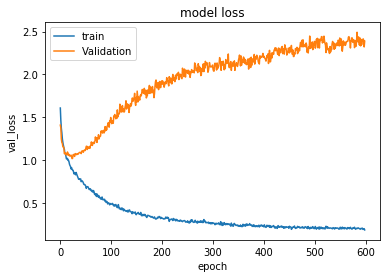

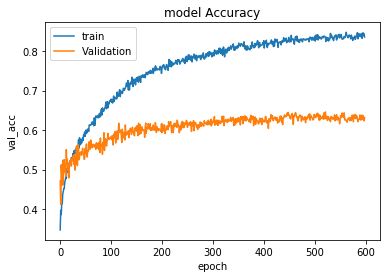

Loading Best Model
1.050011164080174
Train on 6276 samples, validate on 1572 samples
Epoch 1/600
6276/6276 [==============================] - 1s 196us/step - loss: 2.1832 - acc: 0.2645 - val_loss: 1.4581 - val_acc: 0.3785
Epoch 2/600
6276/6276 [==============================] - 0s 56us/step - loss: 1.6427 - acc: 0.3540 - val_loss: 1.3122 - val_acc: 0.4548
Epoch 3/600
6276/6276 [==============================] - 0s 57us/step - loss: 1.4469 - acc: 0.3818 - val_loss: 1.2134 - val_acc: 0.4816
Epoch 4/600
6276/6276 [==============================] - 0s 50us/step - loss: 1.3628 - acc: 0.3866 - val_loss: 1.2165 - val_acc: 0.4835
Epoch 5/600
6276/6276 [==============================] - 0s 58us/step - loss: 1.3155 - acc: 0.4092 - val_loss: 1.1688 - val_acc: 0.4307
Epoch 6/600
6276/6276 [==============================] - 0s 57us/step - loss: 1.2613 - acc: 0.4181 - val_loss: 1.1459 - val_acc: 0.4968
Epoch 7/600
6276/6276 [==============================] - 0s 56us/step - loss: 1.2164 - acc: 0.4246

6276/6276 [==============================] - 0s 50us/step - loss: 0.6931 - acc: 0.5935 - val_loss: 1.1631 - val_acc: 0.5528
Epoch 61/600
6276/6276 [==============================] - 0s 51us/step - loss: 0.6718 - acc: 0.6004 - val_loss: 1.1601 - val_acc: 0.5229
Epoch 62/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.6633 - acc: 0.6023 - val_loss: 1.1640 - val_acc: 0.5483
Epoch 63/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.6521 - acc: 0.6163 - val_loss: 1.1191 - val_acc: 0.5216
Epoch 64/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.6584 - acc: 0.6090 - val_loss: 1.1524 - val_acc: 0.5420
Epoch 65/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.6557 - acc: 0.6004 - val_loss: 1.1848 - val_acc: 0.5458
Epoch 66/600
6276/6276 [==============================] - 0s 51us/step - loss: 0.6518 - acc: 0.6096 - val_loss: 1.1389 - val_acc: 0.5401
Epoch 67/600
6276/6276 [==============================

Epoch 120/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.4537 - acc: 0.6877 - val_loss: 1.4749 - val_acc: 0.5649
Epoch 121/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.4429 - acc: 0.6976 - val_loss: 1.5223 - val_acc: 0.5757
Epoch 122/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.4357 - acc: 0.6872 - val_loss: 1.4959 - val_acc: 0.5668
Epoch 123/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.4359 - acc: 0.6960 - val_loss: 1.5206 - val_acc: 0.5763
Epoch 124/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.4116 - acc: 0.7004 - val_loss: 1.5377 - val_acc: 0.5732
Epoch 125/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.4211 - acc: 0.7111 - val_loss: 1.5761 - val_acc: 0.5903
Epoch 126/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.4372 - acc: 0.6874 - val_loss: 1.5486 - val_acc: 0.5503
Epoch 127/600
6276/6276 [=========

6276/6276 [==============================] - 0s 48us/step - loss: 0.3409 - acc: 0.7439 - val_loss: 1.7506 - val_acc: 0.5840
Epoch 180/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.3403 - acc: 0.7478 - val_loss: 1.7254 - val_acc: 0.5725
Epoch 181/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.3390 - acc: 0.7454 - val_loss: 1.7541 - val_acc: 0.6043
Epoch 182/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.3561 - acc: 0.7395 - val_loss: 1.6914 - val_acc: 0.5827
Epoch 183/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.3340 - acc: 0.7473 - val_loss: 1.8286 - val_acc: 0.6011
Epoch 184/600
6276/6276 [==============================] - 0s 51us/step - loss: 0.3355 - acc: 0.7570 - val_loss: 1.7463 - val_acc: 0.5808
Epoch 185/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.3431 - acc: 0.7540 - val_loss: 1.7842 - val_acc: 0.5916
Epoch 186/600
6276/6276 [=======================

6276/6276 [==============================] - 0s 48us/step - loss: 0.3017 - acc: 0.7690 - val_loss: 1.8421 - val_acc: 0.6037
Epoch 239/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2895 - acc: 0.7779 - val_loss: 1.9235 - val_acc: 0.5948
Epoch 240/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.2936 - acc: 0.7758 - val_loss: 1.9374 - val_acc: 0.6018
Epoch 241/600
6276/6276 [==============================] - 0s 51us/step - loss: 0.2809 - acc: 0.7854 - val_loss: 1.8851 - val_acc: 0.5865
Epoch 242/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2903 - acc: 0.7753 - val_loss: 1.9172 - val_acc: 0.6120
Epoch 243/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.2792 - acc: 0.7723 - val_loss: 1.9012 - val_acc: 0.6164
Epoch 244/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.3032 - acc: 0.7729 - val_loss: 1.9693 - val_acc: 0.5999
Epoch 245/600
6276/6276 [=======================

6276/6276 [==============================] - 0s 49us/step - loss: 0.2668 - acc: 0.7817 - val_loss: 2.0897 - val_acc: 0.6170
Epoch 298/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2696 - acc: 0.7960 - val_loss: 2.0053 - val_acc: 0.6145
Epoch 299/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2590 - acc: 0.7900 - val_loss: 2.0144 - val_acc: 0.6132
Epoch 300/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2632 - acc: 0.7878 - val_loss: 1.9831 - val_acc: 0.6075
Epoch 301/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2608 - acc: 0.7962 - val_loss: 2.0765 - val_acc: 0.6062
Epoch 302/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2636 - acc: 0.7900 - val_loss: 2.0384 - val_acc: 0.5922
Epoch 303/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.2634 - acc: 0.7925 - val_loss: 2.0007 - val_acc: 0.6088
Epoch 304/600
6276/6276 [=======================

6276/6276 [==============================] - 0s 49us/step - loss: 0.2465 - acc: 0.8045 - val_loss: 2.1034 - val_acc: 0.6177
Epoch 357/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2586 - acc: 0.8047 - val_loss: 2.0734 - val_acc: 0.6101
Epoch 358/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2634 - acc: 0.7919 - val_loss: 2.0906 - val_acc: 0.6132
Epoch 359/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2357 - acc: 0.8086 - val_loss: 2.0436 - val_acc: 0.6196
Epoch 360/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2557 - acc: 0.7954 - val_loss: 2.0612 - val_acc: 0.6107
Epoch 361/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2600 - acc: 0.8004 - val_loss: 2.1937 - val_acc: 0.6177
Epoch 362/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.2479 - acc: 0.8061 - val_loss: 2.1583 - val_acc: 0.6069
Epoch 363/600
6276/6276 [=======================

6276/6276 [==============================] - 0s 50us/step - loss: 0.2259 - acc: 0.8161 - val_loss: 2.2120 - val_acc: 0.6031
Epoch 416/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2276 - acc: 0.8098 - val_loss: 2.1843 - val_acc: 0.6190
Epoch 417/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2341 - acc: 0.8177 - val_loss: 2.1321 - val_acc: 0.6177
Epoch 418/600
6276/6276 [==============================] - 0s 51us/step - loss: 0.2351 - acc: 0.8141 - val_loss: 2.1047 - val_acc: 0.6088
Epoch 419/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.2408 - acc: 0.8172 - val_loss: 2.1102 - val_acc: 0.6101
Epoch 420/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2206 - acc: 0.8161 - val_loss: 2.1661 - val_acc: 0.6145
Epoch 421/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2336 - acc: 0.8147 - val_loss: 2.1633 - val_acc: 0.6043
Epoch 422/600
6276/6276 [=======================

6276/6276 [==============================] - 0s 49us/step - loss: 0.2017 - acc: 0.8255 - val_loss: 2.2876 - val_acc: 0.6183
Epoch 475/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.1966 - acc: 0.8373 - val_loss: 2.3150 - val_acc: 0.6247
Epoch 476/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2175 - acc: 0.8292 - val_loss: 2.2250 - val_acc: 0.6234
Epoch 477/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2050 - acc: 0.8306 - val_loss: 2.1656 - val_acc: 0.6240
Epoch 478/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2211 - acc: 0.8212 - val_loss: 2.1653 - val_acc: 0.6177
Epoch 479/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.2131 - acc: 0.8207 - val_loss: 2.2133 - val_acc: 0.6266
Epoch 480/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2113 - acc: 0.8392 - val_loss: 2.2290 - val_acc: 0.6190
Epoch 481/600
6276/6276 [=======================

6276/6276 [==============================] - 0s 48us/step - loss: 0.2054 - acc: 0.8329 - val_loss: 2.1987 - val_acc: 0.6209
Epoch 534/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.2135 - acc: 0.8298 - val_loss: 2.2804 - val_acc: 0.6170
Epoch 535/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2047 - acc: 0.8319 - val_loss: 2.3209 - val_acc: 0.6310
Epoch 536/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.1983 - acc: 0.8402 - val_loss: 2.3257 - val_acc: 0.6164
Epoch 537/600
6276/6276 [==============================] - 0s 47us/step - loss: 0.2116 - acc: 0.8233 - val_loss: 2.2772 - val_acc: 0.6145
Epoch 538/600
6276/6276 [==============================] - 0s 48us/step - loss: 0.2005 - acc: 0.8316 - val_loss: 2.2550 - val_acc: 0.6113
Epoch 539/600
6276/6276 [==============================] - 0s 50us/step - loss: 0.2150 - acc: 0.8340 - val_loss: 2.2121 - val_acc: 0.6202
Epoch 540/600
6276/6276 [=======================

6276/6276 [==============================] - 0s 50us/step - loss: 0.1924 - acc: 0.8431 - val_loss: 2.3553 - val_acc: 0.6228
Epoch 593/600
6276/6276 [==============================] - 0s 53us/step - loss: 0.2069 - acc: 0.8357 - val_loss: 2.3818 - val_acc: 0.6228
Epoch 594/600
6276/6276 [==============================] - 0s 53us/step - loss: 0.1949 - acc: 0.8512 - val_loss: 2.3177 - val_acc: 0.6183
Epoch 595/600
6276/6276 [==============================] - 0s 52us/step - loss: 0.1872 - acc: 0.8458 - val_loss: 2.3354 - val_acc: 0.6164
Epoch 596/600
6276/6276 [==============================] - 0s 49us/step - loss: 0.2058 - acc: 0.8308 - val_loss: 2.3519 - val_acc: 0.6209
Epoch 597/600
6276/6276 [==============================] - 0s 52us/step - loss: 0.1952 - acc: 0.8509 - val_loss: 2.3728 - val_acc: 0.6164
Epoch 598/600
6276/6276 [==============================] - 0s 51us/step - loss: 0.1936 - acc: 0.8391 - val_loss: 2.4252 - val_acc: 0.6272
Epoch 599/600
6276/6276 [=======================

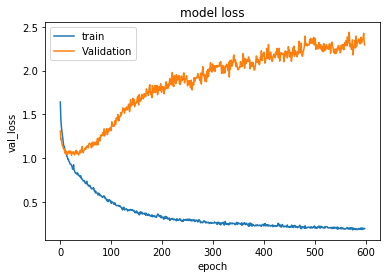

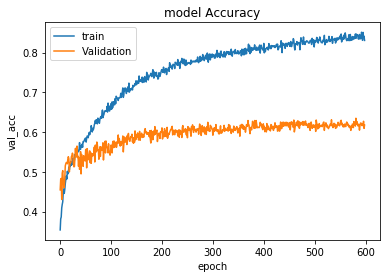

Loading Best Model
1.0370023093625018
Train on 6277 samples, validate on 1571 samples
Epoch 1/600
6277/6277 [==============================] - 1s 232us/step - loss: 2.1356 - acc: 0.2796 - val_loss: 1.4819 - val_acc: 0.4698
Epoch 2/600
6277/6277 [==============================] - 0s 57us/step - loss: 1.6165 - acc: 0.3473 - val_loss: 1.3056 - val_acc: 0.4297
Epoch 3/600
6277/6277 [==============================] - 0s 58us/step - loss: 1.4513 - acc: 0.3757 - val_loss: 1.2393 - val_acc: 0.5086
Epoch 4/600
6277/6277 [==============================] - 0s 57us/step - loss: 1.3463 - acc: 0.4133 - val_loss: 1.2270 - val_acc: 0.3705
Epoch 5/600
6277/6277 [==============================] - 0s 57us/step - loss: 1.3031 - acc: 0.3975 - val_loss: 1.1591 - val_acc: 0.4850
Epoch 6/600
6277/6277 [==============================] - 0s 48us/step - loss: 1.2383 - acc: 0.4214 - val_loss: 1.2140 - val_acc: 0.4609
Epoch 7/600
6277/6277 [==============================] - 0s 50us/step - loss: 1.2214 - acc: 0.423

6277/6277 [==============================] - 0s 49us/step - loss: 0.6597 - acc: 0.5990 - val_loss: 1.1468 - val_acc: 0.5633
Epoch 61/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.6484 - acc: 0.6046 - val_loss: 1.1604 - val_acc: 0.5659
Epoch 62/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.6368 - acc: 0.5958 - val_loss: 1.1855 - val_acc: 0.5506
Epoch 63/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.6309 - acc: 0.6172 - val_loss: 1.1630 - val_acc: 0.5557
Epoch 64/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.6287 - acc: 0.6119 - val_loss: 1.1651 - val_acc: 0.5481
Epoch 65/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.6344 - acc: 0.6097 - val_loss: 1.1861 - val_acc: 0.5519
Epoch 66/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.6383 - acc: 0.6089 - val_loss: 1.2184 - val_acc: 0.5309
Epoch 67/600
6277/6277 [==============================

Epoch 120/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.4633 - acc: 0.6817 - val_loss: 1.5063 - val_acc: 0.5729
Epoch 121/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.4312 - acc: 0.6863 - val_loss: 1.5206 - val_acc: 0.6073
Epoch 122/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.4325 - acc: 0.6892 - val_loss: 1.5359 - val_acc: 0.5983
Epoch 123/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.4362 - acc: 0.7008 - val_loss: 1.5136 - val_acc: 0.5913
Epoch 124/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.4449 - acc: 0.6887 - val_loss: 1.5258 - val_acc: 0.6085
Epoch 125/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.4350 - acc: 0.6976 - val_loss: 1.4956 - val_acc: 0.5996
Epoch 126/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.4383 - acc: 0.6890 - val_loss: 1.5078 - val_acc: 0.6034
Epoch 127/600
6277/6277 [=========

6277/6277 [==============================] - 0s 50us/step - loss: 0.3467 - acc: 0.7383 - val_loss: 1.7118 - val_acc: 0.5996
Epoch 180/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.3558 - acc: 0.7387 - val_loss: 1.6691 - val_acc: 0.6085
Epoch 181/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.3444 - acc: 0.7410 - val_loss: 1.7200 - val_acc: 0.5977
Epoch 182/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.3548 - acc: 0.7445 - val_loss: 1.6726 - val_acc: 0.6155
Epoch 183/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.3402 - acc: 0.7440 - val_loss: 1.7069 - val_acc: 0.6162
Epoch 184/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.3283 - acc: 0.7481 - val_loss: 1.6805 - val_acc: 0.6302
Epoch 185/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.3509 - acc: 0.7469 - val_loss: 1.7130 - val_acc: 0.5977
Epoch 186/600
6277/6277 [=======================

6277/6277 [==============================] - 0s 49us/step - loss: 0.2983 - acc: 0.7687 - val_loss: 1.9366 - val_acc: 0.6219
Epoch 239/600
6277/6277 [==============================] - 0s 47us/step - loss: 0.3156 - acc: 0.7704 - val_loss: 1.8158 - val_acc: 0.6092
Epoch 240/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.3008 - acc: 0.7677 - val_loss: 1.8738 - val_acc: 0.6270
Epoch 241/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2985 - acc: 0.7704 - val_loss: 1.8675 - val_acc: 0.6251
Epoch 242/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.3107 - acc: 0.7752 - val_loss: 1.8241 - val_acc: 0.6136
Epoch 243/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2988 - acc: 0.7704 - val_loss: 1.8782 - val_acc: 0.6149
Epoch 244/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2953 - acc: 0.7655 - val_loss: 1.8797 - val_acc: 0.6334
Epoch 245/600
6277/6277 [=======================

6277/6277 [==============================] - 0s 49us/step - loss: 0.2599 - acc: 0.7948 - val_loss: 2.0393 - val_acc: 0.6283
Epoch 298/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2531 - acc: 0.8106 - val_loss: 2.0481 - val_acc: 0.6289
Epoch 299/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2699 - acc: 0.7945 - val_loss: 2.0234 - val_acc: 0.6302
Epoch 300/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2598 - acc: 0.7932 - val_loss: 1.9745 - val_acc: 0.6225
Epoch 301/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.2629 - acc: 0.7915 - val_loss: 1.9858 - val_acc: 0.6232
Epoch 302/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2484 - acc: 0.7986 - val_loss: 2.1217 - val_acc: 0.6244
Epoch 303/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2625 - acc: 0.7931 - val_loss: 2.0224 - val_acc: 0.6308
Epoch 304/600
6277/6277 [=======================

6277/6277 [==============================] - 0s 49us/step - loss: 0.2536 - acc: 0.7991 - val_loss: 2.0624 - val_acc: 0.6391
Epoch 357/600
6277/6277 [==============================] - 0s 51us/step - loss: 0.2603 - acc: 0.8053 - val_loss: 1.9765 - val_acc: 0.6283
Epoch 358/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2297 - acc: 0.8098 - val_loss: 2.1318 - val_acc: 0.6295
Epoch 359/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2385 - acc: 0.8039 - val_loss: 2.0563 - val_acc: 0.6448
Epoch 360/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2353 - acc: 0.8103 - val_loss: 2.1076 - val_acc: 0.6257
Epoch 361/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2557 - acc: 0.7994 - val_loss: 2.0821 - val_acc: 0.6327
Epoch 362/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.2335 - acc: 0.8045 - val_loss: 2.1891 - val_acc: 0.6435
Epoch 363/600
6277/6277 [=======================

6277/6277 [==============================] - 0s 47us/step - loss: 0.2418 - acc: 0.8176 - val_loss: 2.0141 - val_acc: 0.6073
Epoch 416/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2253 - acc: 0.8080 - val_loss: 2.1107 - val_acc: 0.6378
Epoch 417/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.2273 - acc: 0.8260 - val_loss: 2.1498 - val_acc: 0.6264
Epoch 418/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2419 - acc: 0.8130 - val_loss: 2.0649 - val_acc: 0.6238
Epoch 419/600
6277/6277 [==============================] - 0s 51us/step - loss: 0.2422 - acc: 0.8052 - val_loss: 2.0832 - val_acc: 0.6353
Epoch 420/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.2320 - acc: 0.8158 - val_loss: 2.0919 - val_acc: 0.6225
Epoch 421/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2371 - acc: 0.8154 - val_loss: 2.0691 - val_acc: 0.6232
Epoch 422/600
6277/6277 [=======================

6277/6277 [==============================] - 0s 48us/step - loss: 0.2202 - acc: 0.8224 - val_loss: 2.1411 - val_acc: 0.6244
Epoch 475/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.2080 - acc: 0.8314 - val_loss: 2.1829 - val_acc: 0.6270
Epoch 476/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2094 - acc: 0.8283 - val_loss: 2.2409 - val_acc: 0.6365
Epoch 477/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2127 - acc: 0.8338 - val_loss: 2.0959 - val_acc: 0.6359
Epoch 478/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2075 - acc: 0.8278 - val_loss: 2.1105 - val_acc: 0.6168
Epoch 479/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2099 - acc: 0.8286 - val_loss: 2.1087 - val_acc: 0.6384
Epoch 480/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2100 - acc: 0.8311 - val_loss: 2.1223 - val_acc: 0.6365
Epoch 481/600
6277/6277 [=======================

6277/6277 [==============================] - 0s 50us/step - loss: 0.2230 - acc: 0.8275 - val_loss: 2.2462 - val_acc: 0.6295
Epoch 534/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2213 - acc: 0.8224 - val_loss: 2.1979 - val_acc: 0.6302
Epoch 535/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.1971 - acc: 0.8372 - val_loss: 2.2690 - val_acc: 0.6378
Epoch 536/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.1958 - acc: 0.8404 - val_loss: 2.2530 - val_acc: 0.6334
Epoch 537/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2209 - acc: 0.8357 - val_loss: 2.2515 - val_acc: 0.6251
Epoch 538/600
6277/6277 [==============================] - 0s 51us/step - loss: 0.2075 - acc: 0.8291 - val_loss: 2.3228 - val_acc: 0.6359
Epoch 539/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.1969 - acc: 0.8402 - val_loss: 2.3058 - val_acc: 0.6384
Epoch 540/600
6277/6277 [=======================

6277/6277 [==============================] - 0s 50us/step - loss: 0.1919 - acc: 0.8412 - val_loss: 2.1669 - val_acc: 0.6353
Epoch 593/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.1964 - acc: 0.8424 - val_loss: 2.2190 - val_acc: 0.6429
Epoch 594/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.1874 - acc: 0.8455 - val_loss: 2.2431 - val_acc: 0.6416
Epoch 595/600
6277/6277 [==============================] - 0s 49us/step - loss: 0.2064 - acc: 0.8397 - val_loss: 2.1696 - val_acc: 0.6397
Epoch 596/600
6277/6277 [==============================] - 0s 50us/step - loss: 0.2046 - acc: 0.8367 - val_loss: 2.2421 - val_acc: 0.6334
Epoch 597/600
6277/6277 [==============================] - 0s 51us/step - loss: 0.2038 - acc: 0.8351 - val_loss: 2.2569 - val_acc: 0.6264
Epoch 598/600
6277/6277 [==============================] - 0s 48us/step - loss: 0.1977 - acc: 0.8389 - val_loss: 2.2813 - val_acc: 0.6276
Epoch 599/600
6277/6277 [=======================

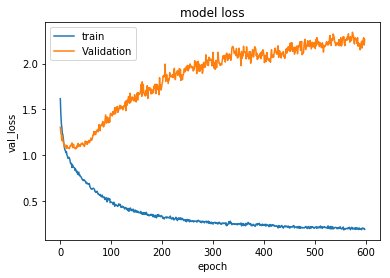

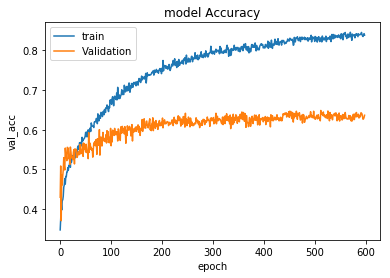

Loading Best Model
1.0848819835291534
Train on 6281 samples, validate on 1567 samples
Epoch 1/600
6281/6281 [==============================] - 2s 273us/step - loss: 2.2028 - acc: 0.2734 - val_loss: 1.4169 - val_acc: 0.4671
Epoch 2/600
6281/6281 [==============================] - 0s 58us/step - loss: 1.6246 - acc: 0.3597 - val_loss: 1.2974 - val_acc: 0.4020
Epoch 3/600
6281/6281 [==============================] - 0s 56us/step - loss: 1.4530 - acc: 0.3745 - val_loss: 1.2252 - val_acc: 0.3937
Epoch 4/600
6281/6281 [==============================] - 0s 50us/step - loss: 1.3694 - acc: 0.3837 - val_loss: 1.2610 - val_acc: 0.4505
Epoch 5/600
6281/6281 [==============================] - 0s 57us/step - loss: 1.2899 - acc: 0.4186 - val_loss: 1.2033 - val_acc: 0.4793
Epoch 6/600
6281/6281 [==============================] - 0s 58us/step - loss: 1.2295 - acc: 0.4203 - val_loss: 1.1823 - val_acc: 0.5144
Epoch 7/600
6281/6281 [==============================] - 0s 57us/step - loss: 1.2001 - acc: 0.437

6281/6281 [==============================] - 0s 48us/step - loss: 0.6853 - acc: 0.5888 - val_loss: 1.2293 - val_acc: 0.5310
Epoch 61/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.6700 - acc: 0.5934 - val_loss: 1.2345 - val_acc: 0.5156
Epoch 62/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.6597 - acc: 0.6085 - val_loss: 1.2085 - val_acc: 0.5131
Epoch 63/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.6540 - acc: 0.6077 - val_loss: 1.2104 - val_acc: 0.5380
Epoch 64/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.6618 - acc: 0.6004 - val_loss: 1.1924 - val_acc: 0.5227
Epoch 65/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.6586 - acc: 0.6104 - val_loss: 1.2135 - val_acc: 0.5424
Epoch 66/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.6275 - acc: 0.6190 - val_loss: 1.1902 - val_acc: 0.5214
Epoch 67/600
6281/6281 [==============================

Epoch 120/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.4391 - acc: 0.6935 - val_loss: 1.5307 - val_acc: 0.5788
Epoch 121/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.4365 - acc: 0.6942 - val_loss: 1.5665 - val_acc: 0.5743
Epoch 122/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.4168 - acc: 0.7039 - val_loss: 1.5359 - val_acc: 0.5909
Epoch 123/600
6281/6281 [==============================] - 0s 51us/step - loss: 0.4401 - acc: 0.6985 - val_loss: 1.5521 - val_acc: 0.5775
Epoch 124/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.4237 - acc: 0.6913 - val_loss: 1.5490 - val_acc: 0.5782
Epoch 125/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.4270 - acc: 0.7099 - val_loss: 1.5180 - val_acc: 0.5629
Epoch 126/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.4211 - acc: 0.7000 - val_loss: 1.4875 - val_acc: 0.5654
Epoch 127/600
6281/6281 [=========

6281/6281 [==============================] - 0s 48us/step - loss: 0.3370 - acc: 0.7524 - val_loss: 1.6832 - val_acc: 0.5858
Epoch 180/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.3568 - acc: 0.7354 - val_loss: 1.7197 - val_acc: 0.5814
Epoch 181/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.3575 - acc: 0.7365 - val_loss: 1.6665 - val_acc: 0.5929
Epoch 182/600
6281/6281 [==============================] - 0s 51us/step - loss: 0.3543 - acc: 0.7389 - val_loss: 1.6710 - val_acc: 0.5814
Epoch 183/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.3475 - acc: 0.7453 - val_loss: 1.6543 - val_acc: 0.5731
Epoch 184/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.3475 - acc: 0.7351 - val_loss: 1.6475 - val_acc: 0.6005
Epoch 185/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.3342 - acc: 0.7532 - val_loss: 1.6666 - val_acc: 0.5871
Epoch 186/600
6281/6281 [=======================

6281/6281 [==============================] - 0s 50us/step - loss: 0.2939 - acc: 0.7711 - val_loss: 1.8996 - val_acc: 0.5992
Epoch 239/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.3225 - acc: 0.7585 - val_loss: 1.8533 - val_acc: 0.5935
Epoch 240/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2944 - acc: 0.7768 - val_loss: 1.9255 - val_acc: 0.5839
Epoch 241/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2764 - acc: 0.7763 - val_loss: 1.9687 - val_acc: 0.5929
Epoch 242/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.3006 - acc: 0.7800 - val_loss: 1.8883 - val_acc: 0.5890
Epoch 243/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2992 - acc: 0.7771 - val_loss: 1.8127 - val_acc: 0.5929
Epoch 244/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.3034 - acc: 0.7642 - val_loss: 1.8583 - val_acc: 0.5814
Epoch 245/600
6281/6281 [=======================

6281/6281 [==============================] - 0s 50us/step - loss: 0.2576 - acc: 0.7953 - val_loss: 2.0323 - val_acc: 0.5941
Epoch 298/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.2735 - acc: 0.7862 - val_loss: 2.0629 - val_acc: 0.5980
Epoch 299/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2535 - acc: 0.7976 - val_loss: 2.0441 - val_acc: 0.5909
Epoch 300/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2794 - acc: 0.7970 - val_loss: 2.0615 - val_acc: 0.5992
Epoch 301/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.2767 - acc: 0.7879 - val_loss: 2.0502 - val_acc: 0.5871
Epoch 302/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2809 - acc: 0.7867 - val_loss: 1.9809 - val_acc: 0.5865
Epoch 303/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2522 - acc: 0.8018 - val_loss: 2.0552 - val_acc: 0.5986
Epoch 304/600
6281/6281 [=======================

6281/6281 [==============================] - 0s 49us/step - loss: 0.2566 - acc: 0.8016 - val_loss: 2.0966 - val_acc: 0.5973
Epoch 357/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2395 - acc: 0.7986 - val_loss: 2.0847 - val_acc: 0.5852
Epoch 358/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2429 - acc: 0.8097 - val_loss: 2.1180 - val_acc: 0.5871
Epoch 359/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2501 - acc: 0.8097 - val_loss: 2.0740 - val_acc: 0.6005
Epoch 360/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.2450 - acc: 0.8152 - val_loss: 2.0763 - val_acc: 0.5980
Epoch 361/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2379 - acc: 0.8161 - val_loss: 2.0894 - val_acc: 0.6011
Epoch 362/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2451 - acc: 0.8091 - val_loss: 2.0855 - val_acc: 0.6011
Epoch 363/600
6281/6281 [=======================

6281/6281 [==============================] - 0s 50us/step - loss: 0.2301 - acc: 0.8166 - val_loss: 2.1697 - val_acc: 0.5960
Epoch 416/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2205 - acc: 0.8201 - val_loss: 2.2277 - val_acc: 0.5980
Epoch 417/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2352 - acc: 0.8171 - val_loss: 2.2548 - val_acc: 0.5922
Epoch 418/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2320 - acc: 0.8183 - val_loss: 2.1584 - val_acc: 0.5986
Epoch 419/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2255 - acc: 0.8163 - val_loss: 2.2069 - val_acc: 0.5948
Epoch 420/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2202 - acc: 0.8199 - val_loss: 2.2066 - val_acc: 0.5999
Epoch 421/600
6281/6281 [==============================] - 0s 52us/step - loss: 0.2383 - acc: 0.8056 - val_loss: 2.1501 - val_acc: 0.6018
Epoch 422/600
6281/6281 [=======================

6281/6281 [==============================] - 0s 49us/step - loss: 0.2373 - acc: 0.8274 - val_loss: 2.2137 - val_acc: 0.5980
Epoch 475/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.2237 - acc: 0.8247 - val_loss: 2.2704 - val_acc: 0.6024
Epoch 476/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2206 - acc: 0.8314 - val_loss: 2.2513 - val_acc: 0.5960
Epoch 477/600
6281/6281 [==============================] - 0s 48us/step - loss: 0.2077 - acc: 0.8290 - val_loss: 2.2239 - val_acc: 0.6063
Epoch 478/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2160 - acc: 0.8330 - val_loss: 2.1915 - val_acc: 0.6018
Epoch 479/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2043 - acc: 0.8355 - val_loss: 2.1800 - val_acc: 0.6120
Epoch 480/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2129 - acc: 0.8330 - val_loss: 2.1999 - val_acc: 0.6165
Epoch 481/600
6281/6281 [=======================

6281/6281 [==============================] - 0s 50us/step - loss: 0.2211 - acc: 0.8271 - val_loss: 2.1848 - val_acc: 0.5935
Epoch 534/600
6281/6281 [==============================] - 0s 51us/step - loss: 0.2130 - acc: 0.8308 - val_loss: 2.2183 - val_acc: 0.6094
Epoch 535/600
6281/6281 [==============================] - 0s 52us/step - loss: 0.2192 - acc: 0.8226 - val_loss: 2.2477 - val_acc: 0.6043
Epoch 536/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2058 - acc: 0.8414 - val_loss: 2.2542 - val_acc: 0.6031
Epoch 537/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.2058 - acc: 0.8314 - val_loss: 2.2478 - val_acc: 0.6011
Epoch 538/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2110 - acc: 0.8325 - val_loss: 2.2234 - val_acc: 0.6018
Epoch 539/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.2111 - acc: 0.8327 - val_loss: 2.2588 - val_acc: 0.5999
Epoch 540/600
6281/6281 [=======================

6281/6281 [==============================] - 0s 50us/step - loss: 0.1802 - acc: 0.8499 - val_loss: 2.3231 - val_acc: 0.6024
Epoch 593/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.1865 - acc: 0.8421 - val_loss: 2.3019 - val_acc: 0.5960
Epoch 594/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.1820 - acc: 0.8486 - val_loss: 2.2958 - val_acc: 0.5948
Epoch 595/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.1960 - acc: 0.8408 - val_loss: 2.2478 - val_acc: 0.5967
Epoch 596/600
6281/6281 [==============================] - 0s 52us/step - loss: 0.1966 - acc: 0.8344 - val_loss: 2.3067 - val_acc: 0.5922
Epoch 597/600
6281/6281 [==============================] - 0s 50us/step - loss: 0.1854 - acc: 0.8446 - val_loss: 2.3356 - val_acc: 0.6011
Epoch 598/600
6281/6281 [==============================] - 0s 49us/step - loss: 0.1903 - acc: 0.8397 - val_loss: 2.3248 - val_acc: 0.6107
Epoch 599/600
6281/6281 [=======================

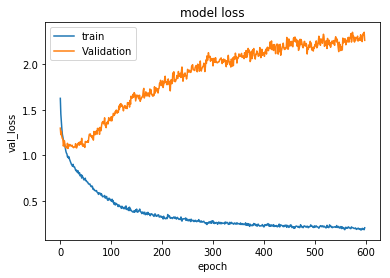

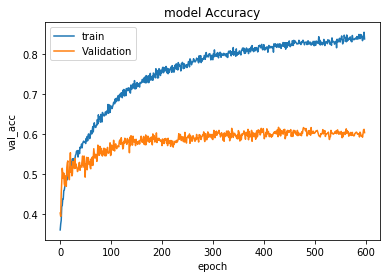

Loading Best Model
1.1306850113036377
Train on 6284 samples, validate on 1564 samples
Epoch 1/600
6284/6284 [==============================] - 2s 332us/step - loss: 2.2706 - acc: 0.2721 - val_loss: 1.4157 - val_acc: 0.4661
Epoch 2/600
6284/6284 [==============================] - 0s 60us/step - loss: 1.6314 - acc: 0.3609 - val_loss: 1.2938 - val_acc: 0.4143
Epoch 3/600
6284/6284 [==============================] - 0s 60us/step - loss: 1.4580 - acc: 0.3701 - val_loss: 1.2475 - val_acc: 0.4629
Epoch 4/600
6284/6284 [==============================] - 0s 61us/step - loss: 1.3564 - acc: 0.4029 - val_loss: 1.1838 - val_acc: 0.4712
Epoch 5/600
6284/6284 [==============================] - 0s 59us/step - loss: 1.3079 - acc: 0.4115 - val_loss: 1.1785 - val_acc: 0.4533
Epoch 6/600
6284/6284 [==============================] - 0s 58us/step - loss: 1.2537 - acc: 0.4192 - val_loss: 1.1012 - val_acc: 0.5032
Epoch 7/600
6284/6284 [==============================] - 0s 57us/step - loss: 1.2540 - acc: 0.435

6284/6284 [==============================] - 0s 50us/step - loss: 0.6882 - acc: 0.5885 - val_loss: 1.1291 - val_acc: 0.5588
Epoch 61/600
6284/6284 [==============================] - 0s 48us/step - loss: 0.6844 - acc: 0.6022 - val_loss: 1.0927 - val_acc: 0.5256
Epoch 62/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.6739 - acc: 0.6038 - val_loss: 1.1327 - val_acc: 0.5294
Epoch 63/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.6488 - acc: 0.5996 - val_loss: 1.1261 - val_acc: 0.5684
Epoch 64/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.6667 - acc: 0.6096 - val_loss: 1.0934 - val_acc: 0.5352
Epoch 65/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.6483 - acc: 0.5999 - val_loss: 1.1483 - val_acc: 0.5492
Epoch 66/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.6519 - acc: 0.6186 - val_loss: 1.1298 - val_acc: 0.5409
Epoch 67/600
6284/6284 [==============================

Epoch 120/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.4692 - acc: 0.6852 - val_loss: 1.4381 - val_acc: 0.5850
Epoch 121/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.4605 - acc: 0.6879 - val_loss: 1.4544 - val_acc: 0.5716
Epoch 122/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.4580 - acc: 0.6983 - val_loss: 1.3821 - val_acc: 0.5710
Epoch 123/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.4374 - acc: 0.6881 - val_loss: 1.5179 - val_acc: 0.5921
Epoch 124/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.4270 - acc: 0.6983 - val_loss: 1.5085 - val_acc: 0.5742
Epoch 125/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.4341 - acc: 0.6932 - val_loss: 1.4569 - val_acc: 0.5882
Epoch 126/600
6284/6284 [==============================] - 0s 48us/step - loss: 0.4288 - acc: 0.7061 - val_loss: 1.4754 - val_acc: 0.5972
Epoch 127/600
6284/6284 [=========

6284/6284 [==============================] - 0s 50us/step - loss: 0.3468 - acc: 0.7425 - val_loss: 1.6639 - val_acc: 0.5985
Epoch 180/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.3481 - acc: 0.7443 - val_loss: 1.6500 - val_acc: 0.5953
Epoch 181/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.3586 - acc: 0.7371 - val_loss: 1.6142 - val_acc: 0.6215
Epoch 182/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.3500 - acc: 0.7497 - val_loss: 1.6191 - val_acc: 0.5972
Epoch 183/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.3334 - acc: 0.7420 - val_loss: 1.6737 - val_acc: 0.6106
Epoch 184/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.3463 - acc: 0.7498 - val_loss: 1.6873 - val_acc: 0.6017
Epoch 185/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.3319 - acc: 0.7522 - val_loss: 1.7039 - val_acc: 0.6119
Epoch 186/600
6284/6284 [=======================

6284/6284 [==============================] - 0s 52us/step - loss: 0.3114 - acc: 0.7702 - val_loss: 1.8586 - val_acc: 0.6151
Epoch 239/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.3099 - acc: 0.7669 - val_loss: 1.8387 - val_acc: 0.6049
Epoch 240/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.3107 - acc: 0.7635 - val_loss: 1.8269 - val_acc: 0.6100
Epoch 241/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2905 - acc: 0.7801 - val_loss: 1.8247 - val_acc: 0.6119
Epoch 242/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.3013 - acc: 0.7740 - val_loss: 1.8206 - val_acc: 0.5985
Epoch 243/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2930 - acc: 0.7734 - val_loss: 1.8367 - val_acc: 0.6010
Epoch 244/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.3147 - acc: 0.7766 - val_loss: 1.8218 - val_acc: 0.5882
Epoch 245/600
6284/6284 [=======================

6284/6284 [==============================] - 0s 50us/step - loss: 0.2564 - acc: 0.7979 - val_loss: 1.9765 - val_acc: 0.6081
Epoch 298/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2739 - acc: 0.7954 - val_loss: 1.9172 - val_acc: 0.6081
Epoch 299/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2658 - acc: 0.7901 - val_loss: 1.9563 - val_acc: 0.6138
Epoch 300/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2731 - acc: 0.7936 - val_loss: 1.9262 - val_acc: 0.6119
Epoch 301/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2581 - acc: 0.7938 - val_loss: 1.8631 - val_acc: 0.6081
Epoch 302/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.2728 - acc: 0.7906 - val_loss: 2.0262 - val_acc: 0.6151
Epoch 303/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.2801 - acc: 0.7931 - val_loss: 1.8877 - val_acc: 0.5991
Epoch 304/600
6284/6284 [=======================

6284/6284 [==============================] - 0s 51us/step - loss: 0.2480 - acc: 0.8114 - val_loss: 2.0330 - val_acc: 0.6202
Epoch 357/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2420 - acc: 0.8157 - val_loss: 2.0418 - val_acc: 0.6208
Epoch 358/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2530 - acc: 0.8063 - val_loss: 1.9832 - val_acc: 0.6260
Epoch 359/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2359 - acc: 0.8106 - val_loss: 1.9872 - val_acc: 0.6292
Epoch 360/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2562 - acc: 0.8027 - val_loss: 1.9236 - val_acc: 0.6132
Epoch 361/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.2474 - acc: 0.8133 - val_loss: 1.9763 - val_acc: 0.6272
Epoch 362/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2443 - acc: 0.8109 - val_loss: 1.9734 - val_acc: 0.6157
Epoch 363/600
6284/6284 [=======================

6284/6284 [==============================] - 0s 53us/step - loss: 0.2392 - acc: 0.8105 - val_loss: 2.1122 - val_acc: 0.6125
Epoch 416/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.2417 - acc: 0.8105 - val_loss: 2.1501 - val_acc: 0.6228
Epoch 417/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2277 - acc: 0.8208 - val_loss: 2.1459 - val_acc: 0.6240
Epoch 418/600
6284/6284 [==============================] - 0s 48us/step - loss: 0.2367 - acc: 0.8227 - val_loss: 2.1462 - val_acc: 0.6061
Epoch 419/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.2233 - acc: 0.8186 - val_loss: 2.1540 - val_acc: 0.6170
Epoch 420/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2257 - acc: 0.8275 - val_loss: 2.0538 - val_acc: 0.6151
Epoch 421/600
6284/6284 [==============================] - 0s 54us/step - loss: 0.2197 - acc: 0.8232 - val_loss: 2.0885 - val_acc: 0.6164
Epoch 422/600
6284/6284 [=======================

6284/6284 [==============================] - 0s 52us/step - loss: 0.2143 - acc: 0.8297 - val_loss: 2.2275 - val_acc: 0.6125
Epoch 475/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.2241 - acc: 0.8270 - val_loss: 2.2141 - val_acc: 0.6125
Epoch 476/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2101 - acc: 0.8259 - val_loss: 2.2097 - val_acc: 0.6240
Epoch 477/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2155 - acc: 0.8291 - val_loss: 2.2042 - val_acc: 0.6113
Epoch 478/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.2269 - acc: 0.8192 - val_loss: 2.2224 - val_acc: 0.6189
Epoch 479/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.2155 - acc: 0.8286 - val_loss: 2.2357 - val_acc: 0.6132
Epoch 480/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.2160 - acc: 0.8340 - val_loss: 2.2264 - val_acc: 0.6145
Epoch 481/600
6284/6284 [=======================

6284/6284 [==============================] - 0s 51us/step - loss: 0.1944 - acc: 0.8372 - val_loss: 2.3238 - val_acc: 0.6228
Epoch 534/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2136 - acc: 0.8377 - val_loss: 2.2332 - val_acc: 0.6183
Epoch 535/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.1973 - acc: 0.8393 - val_loss: 2.3114 - val_acc: 0.6176
Epoch 536/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2078 - acc: 0.8374 - val_loss: 2.3447 - val_acc: 0.6215
Epoch 537/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2058 - acc: 0.8331 - val_loss: 2.2600 - val_acc: 0.6228
Epoch 538/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.2056 - acc: 0.8340 - val_loss: 2.3081 - val_acc: 0.6215
Epoch 539/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.2039 - acc: 0.8372 - val_loss: 2.3544 - val_acc: 0.6196
Epoch 540/600
6284/6284 [=======================

6284/6284 [==============================] - 0s 52us/step - loss: 0.1896 - acc: 0.8409 - val_loss: 2.2488 - val_acc: 0.6189
Epoch 593/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.1937 - acc: 0.8313 - val_loss: 2.2355 - val_acc: 0.6189
Epoch 594/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.2096 - acc: 0.8418 - val_loss: 2.2885 - val_acc: 0.6151
Epoch 595/600
6284/6284 [==============================] - 0s 51us/step - loss: 0.2008 - acc: 0.8398 - val_loss: 2.2410 - val_acc: 0.6272
Epoch 596/600
6284/6284 [==============================] - 0s 50us/step - loss: 0.1987 - acc: 0.8417 - val_loss: 2.3053 - val_acc: 0.6202
Epoch 597/600
6284/6284 [==============================] - 0s 49us/step - loss: 0.2083 - acc: 0.8436 - val_loss: 2.2649 - val_acc: 0.6202
Epoch 598/600
6284/6284 [==============================] - 0s 52us/step - loss: 0.1948 - acc: 0.8407 - val_loss: 2.2300 - val_acc: 0.6170
Epoch 599/600
6284/6284 [=======================

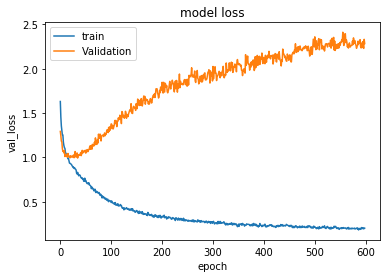

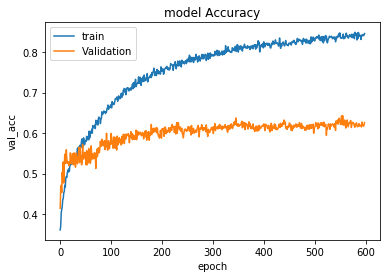

Loading Best Model
1.0011056993650767
MULTI WEIGHTED LOG LOSS : 1.06069 


In [13]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 300
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='sigmoid')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=1,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [14]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [16]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

26631

Normalized confusion matrix
[[7.42e-01 0.00e+00 5.30e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.85e-01 0.00e+00 0.00e+00 6.62e-03 1.32e-02 0.00e+00]
 [4.04e-03 5.35e-01 0.00e+00 7.27e-02 4.24e-02 2.02e-03 1.01e-01 5.66e-02
  0.00e+00 5.25e-02 8.08e-03 9.29e-02 0.00e+00 3.23e-02]
 [2.71e-02 1.08e-03 8.55e-01 0.00e+00 0.00e+00 2.16e-03 0.00e+00 0.00e+00
  9.09e-02 0.00e+00 0.00e+00 0.00e+00 2.38e-02 0.00e+00]
 [0.00e+00 1.59e-01 0.00e+00 1.76e-01 8.97e-02 0.00e+00 2.10e-01 6.87e-02
  0.00e+00 1.10e-01 3.35e-03 1.45e-01 0.00e+00 3.77e-02]
 [0.00e+00 8.20e-02 0.00e+00 8.74e-02 2.73e-01 0.00e+00 1.20e-01 7.65e-02
  0.00e+00 1.09e-01 1.09e-02 2.35e-01 0.00e+00 5.46e-03]
 [3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.00e-01 0.00e+00 0.00e+00
  3.33e-02 0.00e+00 0.00e+00 0.00e+00 3.33e-02 0.00e+00]
 [0.00e+00 1.03e-01 0.00e+00 1.05e-01 9.92e-02 2.07e-03 3.24e-01 1.01e-01
  0.00e+00 1.40e-01 4.13e-03 1.05e-01 0.00e+00 1.45e-02]
 [0.00e+00 1.96e-02 0.00e+00 2.94e-02 5.88e-02 0.00e+00

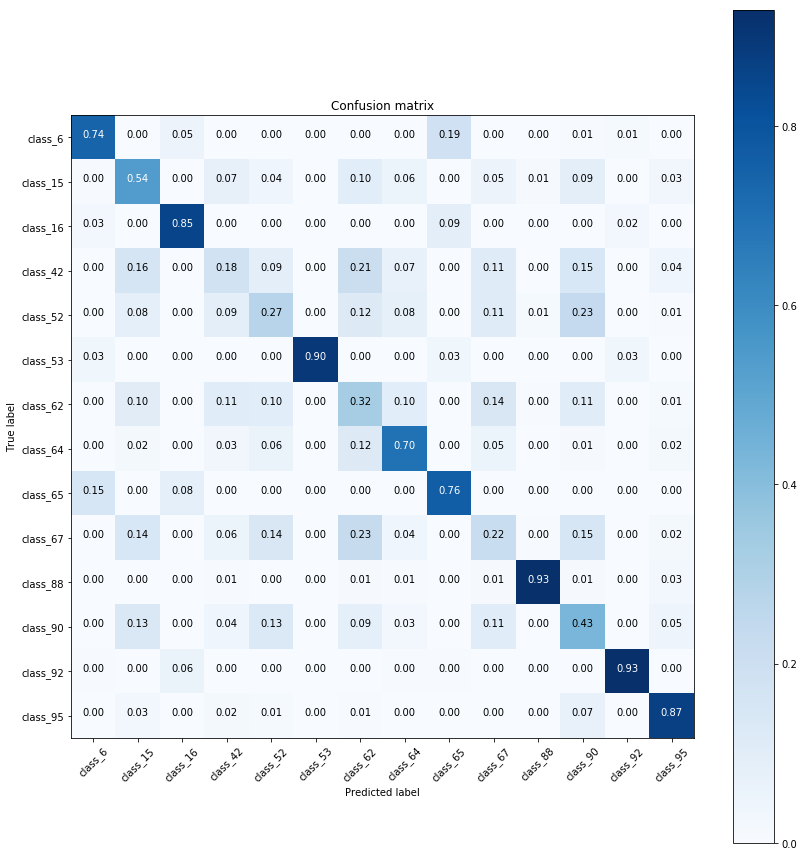

In [17]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [18]:
meta_test = pd.read_csv('test_set_metadata.csv')
sn_test = pd.read_csv('supernova_test.csv')

import time

headis = ['object_id','mjd','passband','flux','flux_err','detected']

skips = [0, 9234918, 18406171, 27609073, 37041469, 46197790, 55770062, 64926393, 74082924, 83421236, 92557978, 102091641, 111228285,
        120365006, 129501800, 137843882, 148172034, 157308879, 166445472, 175979221, 185116017, 194649736, 203786228, 212922916,
        222059646, 231593331, 240730004, 249866875, 259003404, 268537163, 277673872, 286810516, 296344221, 305481051, 314617603,
        324151351, 333288179, 342424765, 351958414, 361095248, 370231906, 379765602, 388902239, 398038933, 407175651, 416709263,
        425846082, 434982658, 444119308, 453653104]

start = time.time()

for i_c in range(0, 49):
    df = pd.read_csv('test_set.csv', names = headis, header=None, skiprows = skips[i_c]+1, nrows = (skips[i_c+1] - skips[i_c]), low_memory = False)
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    df_det = df.where(df['detected'] == 1)
    df_u = df_det.where(df['passband'] == 0)
    df_g = df_det.where(df['passband'] == 1)
    df_r = df_det.where(df['passband'] == 2)
    df_i = df_det.where(df['passband'] == 3)
    df_z = df_det.where(df['passband'] == 4)
    df_y = df_det.where(df['passband'] == 5)
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test_det = df_det.groupby('object_id').agg(aggs_det)
    agg_test_u = df_u.groupby('object_id').agg(aggs_bands)
    agg_test_g = df_g.groupby('object_id').agg(aggs_bands)
    agg_test_r = df_r.groupby('object_id').agg(aggs_bands)
    agg_test_i = df_i.groupby('object_id').agg(aggs_bands)
    agg_test_z = df_z.groupby('object_id').agg(aggs_bands)
    agg_test_y = df_y.groupby('object_id').agg(aggs_bands)
    agg_test.columns = new_columns
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']
    agg_test_det.columns = new_columns_det
    agg_test_det['mjd_diff'] = agg_test_det['mjd_max'] - agg_test_det['mjd_min']
    agg_test_det['flux_diff'] = agg_test_det['flux_max'] - agg_test_det['flux_min']
    agg_test_det['flux_kurt'] = df_det.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    
    mjd_fluxmax_ind = df_det.groupby('object_id')['flux'].idxmax()
    flux_mjdmax_ind = df_det.groupby('object_id')['mjd'].idxmax()
    flux_mjdmin_ind = df_det.groupby('object_id')['mjd'].idxmin()
    mjd_fluxmax_set = df_det.iloc[mjd_fluxmax_ind].values[:,1]
    flux_mjdmax_set = df_det.iloc[flux_mjdmax_ind].values[:,3]
    flux_mjdmin_set = df_det.iloc[flux_mjdmin_ind].values[:,3]
    agg_test_det['mjd_fluxmax'] = mjd_fluxmax_set
    agg_test_det['flux_mjdmax'] = flux_mjdmax_set
    agg_test_det['flux_mjdmin'] = flux_mjdmin_set

    agg_test_u.columns = new_columns_bands
    agg_test_u['flux_kurt'] = df_u.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    agg_test_g.columns = new_columns_bands
    agg_test_g['flux_kurt'] = df_g.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    agg_test_r.columns = new_columns_bands
    agg_test_r['flux_kurt'] = df_r.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    agg_test_i.columns = new_columns_bands
    agg_test_i['flux_kurt'] = df_i.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    agg_test_z.columns = new_columns_bands
    agg_test_z['flux_kurt'] = df_z.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    agg_test_y.columns = new_columns_bands
    agg_test_y['flux_kurt'] = df_y.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)

    agg_test_det.columns = agg_test_det.columns + "_det"
    agg_test_u.columns = agg_test_u.columns + "_u"
    agg_test_g.columns = agg_test_g.columns + "_g"
    agg_test_r.columns = agg_test_r.columns + "_r"
    agg_test_i.columns = agg_test_i.columns + "_i"
    agg_test_z.columns = agg_test_z.columns + "_z"
    agg_test_y.columns = agg_test_y.columns + "_y"
    
    del mjd_fluxmax_ind, flux_mjdmax_ind, flux_mjdmin_ind, mjd_fluxmax_set, flux_mjdmax_set, flux_mjdmin_set
    del agg_test_det['mjd_max_det'], agg_test_det['mjd_min_det']
    del agg_test_det['flux_max_det'], agg_test_det['flux_min_det']
    del agg_test_det['mjd_fluxmax_det'], agg_test_det['flux_mjdmax_det'], agg_test_det['flux_mjdmin_det']
    
    agg_test = pd.concat([agg_test, agg_test_det, agg_test_u, agg_test_g, agg_test_r, agg_test_i, agg_test_z, agg_test_y], axis=1, join='inner')

    agg_test.index = agg_test.index.map(int)
    agg_test.index.name = 'object_id'

    del df, df_det, df_u, df_g, df_r, df_i, df_z, df_y
    gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    
    full_test = full_test.reset_index().merge(
        right=sn_test,
        how='outer',
        on='object_id'
    )
    
    full_test['distmod'].fillna(0, inplace=True)
    
    full_test['abs_mag'] = -2.5*np.log10(full_test['flux_max']) - full_test['distmod']
    full_test['abs_mag_uband'] = -2.5*np.log10(full_test['flux_max_u']) - full_test['distmod']
    full_test['abs_mag_gband'] = -2.5*np.log10(full_test['flux_max_g']) - full_test['distmod']
    full_test['abs_mag_rband'] = -2.5*np.log10(full_test['flux_max_r']) - full_test['distmod']
    full_test['abs_mag_iband'] = -2.5*np.log10(full_test['flux_max_i']) - full_test['distmod']
    full_test['abs_mag_zband'] = -2.5*np.log10(full_test['flux_max_z']) - full_test['distmod']
    full_test['abs_mag_yband'] = -2.5*np.log10(full_test['flux_max_y']) - full_test['distmod']
    full_test['abs_mag_u_g_band'] = full_test['abs_mag_uband'] - full_test['abs_mag_gband']
    full_test['abs_mag_g_r_band'] = full_test['abs_mag_gband'] - full_test['abs_mag_rband']
    full_test['abs_mag_r_i_band'] = full_test['abs_mag_rband'] - full_test['abs_mag_iband']
    full_test['abs_mag_i_z_band'] = full_test['abs_mag_iband'] - full_test['abs_mag_zband']
    full_test['abs_mag_z_y_band'] = full_test['abs_mag_zband'] - full_test['abs_mag_yband']
    full_test['t0_u_t0_g'] = full_test['t_0_u'] - full_test['t_0_g']
    full_test['t0_g_t0_r'] = full_test['t_0_g'] - full_test['t_0_r']
    full_test['t0_r_t0_i'] = full_test['t_0_r'] - full_test['t_0_i']
    full_test['t0_i_t0_z'] = full_test['t_0_i'] - full_test['t_0_z']
    full_test['t0_z_t0_y'] = full_test['t_0_z'] - full_test['t_0_y']
    full_test['fit_maxflux_u'] = 0.5*full_test['A_u'] + full_test['B_u']
    full_test['fit_maxflux_g'] = 0.5*full_test['A_g'] + full_test['B_g']
    full_test['fit_maxflux_r'] = 0.5*full_test['A_r'] + full_test['B_r']
    full_test['fit_maxflux_i'] = 0.5*full_test['A_i'] + full_test['B_i']
    full_test['fit_maxflux_z'] = 0.5*full_test['A_z'] + full_test['B_z']
    full_test['fit_maxflux_y'] = 0.5*full_test['A_y'] + full_test['B_y']
    full_test['fit_abs_mag_u'] = -2.5*np.log10(full_test['fit_maxflux_u']) - full_test['distmod']
    full_test['fit_abs_mag_g'] = -2.5*np.log10(full_test['fit_maxflux_g']) - full_test['distmod']
    full_test['fit_abs_mag_r'] = -2.5*np.log10(full_test['fit_maxflux_r']) - full_test['distmod']
    full_test['fit_abs_mag_i'] = -2.5*np.log10(full_test['fit_maxflux_i']) - full_test['distmod']
    full_test['fit_abs_mag_z'] = -2.5*np.log10(full_test['fit_maxflux_z']) - full_test['distmod']
    full_test['fit_abs_mag_y'] = -2.5*np.log10(full_test['fit_maxflux_y']) - full_test['distmod']
    full_test['fit_max_u_max_g'] = full_test['fit_maxflux_u'] - full_test['fit_maxflux_g']
    full_test['fit_max_g_max_r'] = full_test['fit_maxflux_g'] - full_test['fit_maxflux_r']
    full_test['fit_max_r_max_i'] = full_test['fit_maxflux_r'] - full_test['fit_maxflux_i']
    full_test['fit_max_i_max_z'] = full_test['fit_maxflux_i'] - full_test['fit_maxflux_z']
    full_test['fit_max_z_max_y'] = full_test['fit_maxflux_z'] - full_test['fit_maxflux_y']
    full_test['A_u'] = np.log10(full_test['A_u'])
    full_test['B_u'] = np.log10(full_test['B_u'])
    full_test['A_g'] = np.log10(full_test['A_g'])
    full_test['B_g'] = np.log10(full_test['B_g'])
    full_test['A_r'] = np.log10(full_test['A_r'])
    full_test['B_r'] = np.log10(full_test['B_r'])
    full_test['A_i'] = np.log10(full_test['A_i'])
    full_test['B_i'] = np.log10(full_test['B_i'])
    full_test['A_z'] = np.log10(full_test['A_z'])
    full_test['B_z'] = np.log10(full_test['B_z'])
    full_test['A_y'] = np.log10(full_test['A_y'])
    full_test['B_y'] = np.log10(full_test['B_y'])
    full_test['A_u'].fillna(-100, inplace=True)
    full_test['B_u'].fillna(-100, inplace=True)
    full_test['A_g'].fillna(-100, inplace=True)
    full_test['B_g'].fillna(-100, inplace=True)
    full_test['A_r'].fillna(-100, inplace=True)
    full_test['B_r'].fillna(-100, inplace=True)
    full_test['A_i'].fillna(-100, inplace=True)
    full_test['B_i'].fillna(-100, inplace=True)
    full_test['A_z'].fillna(-100, inplace=True)
    full_test['B_z'].fillna(-100, inplace=True)
    full_test['A_y'].fillna(-100, inplace=True)
    full_test['B_y'].fillna(-100, inplace=True)
    full_test['cost_u'] = np.log10(full_test['cost_u'])
    full_test['cost_g'] = np.log10(full_test['cost_g'])
    full_test['cost_r'] = np.log10(full_test['cost_r'])
    full_test['cost_i'] = np.log10(full_test['cost_i'])
    full_test['cost_z'] = np.log10(full_test['cost_z'])
    full_test['cost_y'] = np.log10(full_test['cost_y'])
    
    del full_test['hostgal_specz']
    del full_test['ra'], full_test['decl'], full_test['gal_l'],full_test['gal_b'],full_test['ddf']

    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions_newmodels.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions_newmodels.csv',  header=False, mode='a', index=False)
        
    del agg_test, agg_test_det, full_test, preds_df, preds
#     print('done')
    print('%15d done in %5.1f' % ((i_c + 1), (time.time() - start) / 60))

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log10
C:\Users\Ross\Anaconda3\lib\site-package

KeyboardInterrupt: 

In [ ]:
z = pd.read_csv('predictions_newmodels.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z_new = z
z_new["sum"] = z_new.sum(axis=1)

z_new = z_new.loc[:,"class_6":"class_99"].div(z_new["sum"], axis=0)
z_new.index = z_new.index.map(int)

z_new.to_csv('single_predictions_newmodels.csv', index=True)

In [ ]:
z_new.head()